In [6]:
!git clone https://github.com/javadseraj/bearing-fault-detection.git

Cloning into 'bearing-fault-detection'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 18 (delta 6), reused 3 (delta 0), pack-reused 0
Unpacking objects: 100% (18/18), done.


In [7]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split

In [3]:
print("Tensorflow version: ", tf.__version__)
print("Numpy version: ", np.__version__)
print("Pandas version: ", pd.__version__)
print("Scikit-learn version: ", sklearn.__version__)

Tensorflow version:  2.5.0
Numpy version:  1.19.5
Pandas version:  1.1.5
Scikit-learn version:  0.22.2.post1


In [9]:
 #Clone the repo and run current notebook.
file = np.load("/content/bearing-fault-detection/CWRU_48k_load_1_CNN_wavelet_morlet_data_3class-v2.npz")
print(file.files)

['data', 'labels']


In [10]:
data = file['data']
labels = file['labels']
print(data.shape, labels.shape)

(2760, 32, 32) (2760,)


In [11]:
print(data[1])
print(labels)

[[ 0.01020172 -0.00573013  0.07074878 ... -0.24166405 -0.18484959
  -0.00260397]
 [-0.04192289 -0.09738729  0.25067231 ...  0.47259021 -0.34711233
   0.04998896]
 [-0.11706211 -0.0171799   0.07558984 ...  0.02658318  0.08676461
   0.04282533]
 ...
 [ 0.64861107  0.19022679 -0.01515804 ... -0.79289484 -0.2437574
   0.25301206]
 [ 0.46750858  0.15796137 -0.14604507 ...  0.55664819 -0.063833
  -0.28631657]
 [ 0.129078    0.26094609  0.34046704 ...  0.09026027 -0.12110367
  -0.06255563]]
['Ball_007_Ball_014' 'Ball_007_Ball_014' 'Ball_007_Ball_014' ...
 'OR_007_OR_014' 'OR_007_OR_014' 'OR_007_OR_014']


In [12]:
category_labels = np.unique(labels)
print(category_labels)

['Ball_007_Ball_014' 'IR_007_IR_014' 'OR_007_OR_014']


In [13]:
labels = pd.Categorical(labels, categories = category_labels).codes

In [14]:
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size = 500, random_state = 829,
                                                                   stratify = labels)

In [15]:
# reshape data as input should be three dimensional to a CNN

train_data = train_data.reshape(len(train_data),32,32,1)
test_data = test_data.reshape(len(test_data),32,32,1)

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

# Shuffle data
index = np.random.permutation(len(train_labels))
trian_data, trian_labels = train_data[index], train_labels[index]

print(train_data.shape, train_labels.shape, test_data.shape, test_labels.shape )

(2260, 32, 32, 1) (2260, 3) (500, 32, 32, 1) (500, 3)


In [21]:
demo_model = Sequential([
    layers.Conv2D(32,3,activation= 'relu', input_shape = (32,32,1)),
    #layers.MaxPool2D(2),
    layers.Conv2D(64,5,activation = 'relu'),
    #layers.MaxPool2D(2),
    layers.Flatten(),
    layers.Dense(128,activation = 'relu'),
    layers.Dense(96, activation = 'relu'),
    layers.Dense(3, activation = 'softmax')
])
demo_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 26, 26, 64)        51264     
_________________________________________________________________
flatten_5 (Flatten)          (None, 43264)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               5537920   
_________________________________________________________________
dense_14 (Dense)             (None, 96)                12384     
_________________________________________________________________
dense_15 (Dense)             (None, 3)                 291       
Total params: 5,602,179
Trainable params: 5,602,179
Non-trainable params: 0
____________________________________________

In [23]:
def create_compiled_model():
    model = Sequential([
    layers.Conv2D(32,3,activation= 'relu', input_shape = (32,32,1)),
    layers.MaxPool2D(2),
    layers.Conv2D(64,5,activation = 'relu'),
    layers.MaxPool2D(2),
    layers.Flatten(),
    layers.Dense(128,activation = 'relu'),
    layers.Dense(96, activation = 'relu'),
    layers.Dense(3, activation = 'softmax')
    ])
    model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001), 
                  metrics= ['accuracy'])
    return model

In [24]:
res = np.empty(10)
res[:] = np.nan
for i in range(10):
    model = create_compiled_model()
    history = model.fit(train_data, train_labels, epochs = 35, batch_size = 128, verbose = 0)    # Verbosity is set to zero
    res[i] = model.evaluate(test_data, test_labels, batch_size = 128, verbose = 0)[1]            # Verbosity is set to zero
    print('Loop iteration %d, Accuracy: %4.4f' % (i+1, res[i]))
    if res[i]>=np.max(res[:(i+1)]):
        best_model = model

Loop iteration 1, Accuracy: 0.9960
Loop iteration 2, Accuracy: 0.9940
Loop iteration 3, Accuracy: 0.9960
Loop iteration 4, Accuracy: 0.9960
Loop iteration 5, Accuracy: 0.9960
Loop iteration 6, Accuracy: 0.9940
Loop iteration 7, Accuracy: 0.9960
Loop iteration 8, Accuracy: 0.9960
Loop iteration 9, Accuracy: 0.9960
Loop iteration 10, Accuracy: 0.9920


In [25]:
 print('Average accuracy:%4.4f'%(np.mean(res))) # After running the model 10 times
print("Best accuracy: %4.4f"%(np.max(res)))
print("Worst accuracy: %4.4f"%(np.min(res)))
print('Standard deviation: %4.4f' % (np.std(res)))

Average accuracy:0.9952
Best accuracy: 0.9960
Worst accuracy: 0.9920
Standard deviation: 0.0013


In [26]:
tf.keras.models.save_model(best_model, "CWRU_CNN_continuous_wavelet_transform.h5")

In [27]:
prediction = best_model.predict(test_data)
prediction_labels = list([])
for each_prediction in prediction:
    prediction_labels.append(list(each_prediction).index(max(each_prediction)))

In [28]:
from sklearn.metrics import confusion_matrix
true_labels = np.argmax(test_labels, axis = 1)
matrix = confusion_matrix(true_labels, prediction_labels)

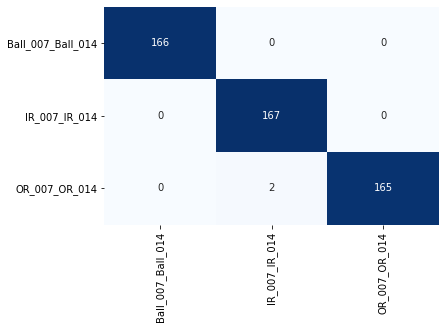

In [29]:
import seaborn as sns
matrix = pd.DataFrame(matrix)
plt.figure()
sns.heatmap(matrix, annot= True, fmt = "d",
           xticklabels = category_labels,
           yticklabels = category_labels, cmap = "Blues", cbar = False)
plt.xticks(rotation = 90)
plt.show()